# Capstone Project -- Hong Kong

## Leah Lu

###  Import necessary libraries

In [346]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from IPython.core.display import HTML

from bs4 import BeautifulSoup
import wikipedia as wp

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


### Step 1 : Explore the data

In [166]:
html = wp.page("Districts_of_Hong_Kong").html().encode("UTF-8")
df = pd.read_html(html)[5]

#Drop column 'Chinese'
df= df.drop(columns=['Chinese'])

#Fix Column name for population
column_names = ['District','Population', 'Area/km^2','Density/km^2','Region']
df.columns = column_names

df.head()

,District,Population,Area/km^2,Density/km^2,Region
0,Central and Western,244600,12.44,19983.92,Hong Kong Island
1,Eastern,574500,18.56,31217.67,Hong Kong Island
2,Southern,269200,38.85,6962.68,Hong Kong Island
3,Wan Chai,150900,9.83,15300.10,Hong Kong Island
4,Sham Shui Po,390600,9.35,41529.41,Kowloon


### Add Latitude and Longitude

In [169]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
df['Dist_Coord']= df['District'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))

df[['Latitude', 'Longitude']] = df['Dist_Coord'].apply(pd.Series)
df.drop(['Dist_Coord'], axis=1, inplace=True)

df.head()

C:\Users\eacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


,District,Population,Area/km^2,Density/km^2,Region,Latitude,Longitude
0,Central and Western,244600,12.44,19983.92,Hong Kong Island,22.281322,114.160258
1,Eastern,574500,18.56,31217.67,Hong Kong Island,1.178718,38.602580
2,Southern,269200,38.85,6962.68,Hong Kong Island,31.990978,-102.071297
3,Wan Chai,150900,9.83,15300.10,Hong Kong Island,22.279015,114.172483
4,Sham Shui Po,390600,9.35,41529.41,Kowloon,22.328190,114.160854


In [170]:
address = 'Hong Kong'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hong Kong are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hong Kong are 22.2793278, 114.1628131.


In [344]:
# create map of Hong Kong using latitude and longitude values
map_HK = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Region, District in zip(df['Latitude'], df['Longitude'], df['Region'], df['District']):
    label = '{}, {}'.format(District, Region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_HK)  
    
HTML(map_HK._repr_html_())

In [172]:
CLIENT_ID = 'TS3DG3GUYO45M32GNAUARULKPO0MH3RFQOIGHMWYIJUL55BJ' # your Foursquare ID
CLIENT_SECRET = 'C05ZSLCGVBFCEG23AFFKEUNXL0QTE3AFZGCQIHBC1FUXOTTU' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
#print(search_query + ' .... OK!')

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

Your credentails:
CLIENT_ID: TS3DG3GUYO45M32GNAUARULKPO0MH3RFQOIGHMWYIJUL55BJ
CLIENT_SECRET:C05ZSLCGVBFCEG23AFFKEUNXL0QTE3AFZGCQIHBC1FUXOTTU


'https://api.foursquare.com/v2/venues/search?client_id=TS3DG3GUYO45M32GNAUARULKPO0MH3RFQOIGHMWYIJUL55BJ&client_secret=C05ZSLCGVBFCEG23AFFKEUNXL0QTE3AFZGCQIHBC1FUXOTTU&ll=22.2793278,114.1628131&v=20180604&radius=500&limit=100'

In [173]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [174]:
#Send the GET request and examine the results
results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",False,4c7b310793ef236a360bb50f,"1-2/F, Fairmont House, 8 Cotton Tree Dr",HK,中環,香港,NaN,69,"[1-2/F, Fairmont House, 8 Cotton Tree Dr, 中西區,...","[{'label': 'display', 'lat': 22.27992542782658...",22.279925,114.163022,NaN,NaN,中西區,Pure Fitness,v-1592432909
1,"[{'id': '5744ccdfe4b0c0459246b4af', 'name': 'P...",False,504958c5e4b04f60bbd8db25,"406 4th Floor, Fairmont House, 8, Cotton Tree ...",HK,NaN,香港,NaN,108,"[406 4th Floor, Fairmont House, 8, Cotton Tree...","[{'label': 'display', 'lat': 22.27949763024468...",22.279498,114.161780,NaN,NaN,NaN,Sports Rehab Physiotherapy (HK) centre,v-1592432909
2,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",False,4b2f4154f964a52077ea24e3,Drake St,HK,金鐘,香港,NaN,180,"[Drake St, 中西區, 香港]","[{'label': 'display', 'lat': 22.279412, 'lng':...",22.279412,114.164559,Central,NaN,中西區,MTR Admiralty Station (港鐵金鐘站),v-1592432909
3,"[{'id': '4bf58dd8d48988d10a951735', 'name': 'B...",False,4b81f422f964a52038c530e3,"G/F., Far East Finance Centre",HK,香港,香港,16 Harcourt Road,173,"[G/F., Far East Finance Centre (16 Harcourt Ro...","[{'label': 'display', 'lat': 22.27986381975870...",22.279864,114.164397,NaN,NaN,NaN,"Bank Negara Indonesia, Hong Kong Branch",v-1592432909
4,"[{'id': '52f2ab2ebcbc57f1066b8b51', 'name': 'T...",False,5348d9eb11d209ad8f41f361,NaN,HK,香港,香港,NaN,37,[香港],"[{'label': 'display', 'lat': 22.27963156384432...",22.279632,114.162656,NaN,NaN,NaN,Tramway,v-1592432909


In [175]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Pure Fitness,Gym,"1-2/F, Fairmont House, 8 Cotton Tree Dr",HK,中環,香港,NaN,69,"[1-2/F, Fairmont House, 8 Cotton Tree Dr, 中西區,...","[{'label': 'display', 'lat': 22.27992542782658...",22.279925,114.163022,NaN,NaN,中西區,4c7b310793ef236a360bb50f
1,Sports Rehab Physiotherapy (HK) centre,Physical Therapist,"406 4th Floor, Fairmont House, 8, Cotton Tree ...",HK,NaN,香港,NaN,108,"[406 4th Floor, Fairmont House, 8, Cotton Tree...","[{'label': 'display', 'lat': 22.27949763024468...",22.279498,114.161780,NaN,NaN,NaN,504958c5e4b04f60bbd8db25
2,MTR Admiralty Station (港鐵金鐘站),Metro Station,Drake St,HK,金鐘,香港,NaN,180,"[Drake St, 中西區, 香港]","[{'label': 'display', 'lat': 22.279412, 'lng':...",22.279412,114.164559,Central,NaN,中西區,4b2f4154f964a52077ea24e3
3,"Bank Negara Indonesia, Hong Kong Branch",Bank,"G/F., Far East Finance Centre",HK,香港,香港,16 Harcourt Road,173,"[G/F., Far East Finance Centre (16 Harcourt Ro...","[{'label': 'display', 'lat': 22.27986381975870...",22.279864,114.164397,NaN,NaN,NaN,4b81f422f964a52038c530e3
4,Tramway,Tram Station,NaN,HK,香港,香港,NaN,37,[香港],"[{'label': 'display', 'lat': 22.27963156384432...",22.279632,114.162656,NaN,NaN,NaN,5348d9eb11d209ad8f41f361


In [176]:
#Create function to know how many venues there are in HK

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [177]:
#List of Neighborhood that have venues in HK
HK_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

HK_venues.head()

Central and Western
Eastern
Southern
Wan Chai
Sham Shui Po
Kowloon City
Kwun Tong
Wong Tai Sin
Yau Tsim Mong
Islands
Kwai Tsing
North
Sai Kung
Sha Tin
Tai Po
Tsuen Wan
Tuen Mun
Yuen Long


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central and Western,22.281322,114.160258,Mandarin Grill + Bar (文華扒房＋酒吧),22.281928,114.159408,Steakhouse
1,Central and Western,22.281322,114.160258,Mandarin Oriental Hong Kong (香港文華東方酒店),22.281857,114.159382,Hotel
2,Central and Western,22.281322,114.160258,Mott 32 (卅二公館),22.280286,114.159080,Dim Sum Restaurant
3,Central and Western,22.281322,114.160258,The Mandarin Cake Shop,22.281959,114.159416,Bakery
4,Central and Western,22.281322,114.160258,Dr. Fern's Gin Parlour,22.280985,114.158391,Lounge


In [178]:
print('{} venues were returned by Foursquare.'.format(HK_venues.shape[0]))
HK_venues.head()

679 venues were returned by Foursquare.


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central and Western,22.281322,114.160258,Mandarin Grill + Bar (文華扒房＋酒吧),22.281928,114.159408,Steakhouse
1,Central and Western,22.281322,114.160258,Mandarin Oriental Hong Kong (香港文華東方酒店),22.281857,114.159382,Hotel
2,Central and Western,22.281322,114.160258,Mott 32 (卅二公館),22.280286,114.159080,Dim Sum Restaurant
3,Central and Western,22.281322,114.160258,The Mandarin Cake Shop,22.281959,114.159416,Bakery
4,Central and Western,22.281322,114.160258,Dr. Fern's Gin Parlour,22.280985,114.158391,Lounge


In [179]:
#Number of venues per neighborhood
count= HK_venues.groupby('District').count()
count=count.sort_values(by=['Venue'],ascending=False)
count.head()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Wan Chai,97,97,97,97,97,97
Central and Western,93,93,93,93,93,93
Kowloon City,70,70,70,70,70,70
Kwun Tong,65,65,65,65,65,65
Sha Tin,62,62,62,62,62,62


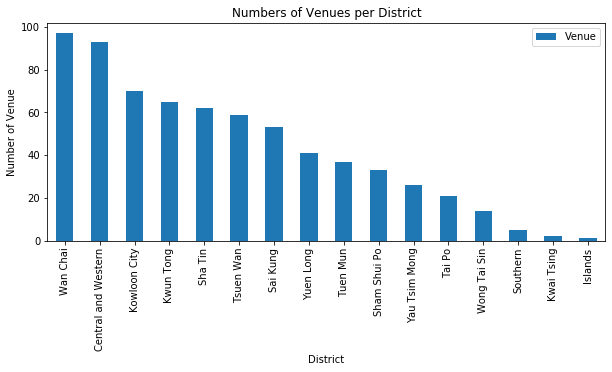

In [180]:
count.drop(['District Latitude','District Longitude','Venue Latitude','Venue Longitude','Venue Category'],inplace=True,axis=1)
count.plot(kind='bar',figsize=(10,4))

plt.xlabel('District')
plt.ylabel('Number of Venue')
plt.title('Numbers of Venues per District')

plt.show()

In [181]:
print('There are {} uniques categories.'.format(len(HK_venues['Venue Category'].unique())))

There are 143 uniques categories.


In [182]:
# one hot encoding
HK_onehot = pd.get_dummies(HK_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
HK_onehot['District'] = HK_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [HK_onehot.columns[-1]] + list(HK_onehot.columns[:-1])
HK_onehot = HK_onehot[fixed_columns]

HK_onehot.head()

,District,Airport Service,American Restaurant,Art Gallery,Asian Restaurant,Astrologer,BBQ Joint,Bakery,Bar,Beach,Beijing Restaurant,Betting Shop,Bistro,Bookstore,Breakfast Spot,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Donburi Restaurant,Dumpling Restaurant,Electronics Store,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Court,French Restaurant,Fujian Restaurant,Furniture / Home Store,Gastropub,General Travel,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Market,Massage Studio,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multiplex,Music Store,Noodle House,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Yunnan Restaurant,Zoo
0,Central and Western,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Central and Western,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Central and Western,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Central and Western,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Central and Western,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [183]:
HK_grouped = HK_onehot.groupby('District').mean().reset_index()
HK_grouped.head()

,District,Airport Service,American Restaurant,Art Gallery,Asian Restaurant,Astrologer,BBQ Joint,Bakery,Bar,Beach,Beijing Restaurant,Betting Shop,Bistro,Bookstore,Breakfast Spot,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Donburi Restaurant,Dumpling Restaurant,Electronics Store,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Court,French Restaurant,Fujian Restaurant,Furniture / Home Store,Gastropub,General Travel,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Market,Massage Studio,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multiplex,Music Store,Noodle House,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio,Yunnan Restaurant,Zoo
0,Central and Western,0.010753,0.010753,0.000000,0.010753,0.0,0.010753,0.010753,0.032258,0.0,0.010753,0.0,0.010753,0.010753,0.0,0.010753,0.0,0.000000,0.010753,0.000000,0.000000,0.0,0.021505,0.021505,0.000000,0.000000,0.043011,0.000000,0.010753,0.021505,0.032258,0.0,0.0,0.010753,0.010753,0.0,0.010753,0.000000,0.0,0.000000,0.010753,0.000000,0.000000,0.010753,0.010753,0.000000,0.0,0.0,0.0,0.043011,0.0,0.000000,0.0,0.010753,0.0,0.0,0.0,0.032258,0.032258,0.000000,0.010753,0.000000,0.0,0.032258,0.021505,0.000000,0.000000,0.0,0.0,0.000000,0.032258,0.043011,0.010753,0.0,0.0,0.0,0.0,0.032258,0.0,0.000000,0.010753,0.0,0.0,0.0,0.0,0.010753,0.0,0.000000,0.0,0.000000,0.010753,0.000000,0.0,0.0,0.0,0.000000,0.0,0.010753,0.0,0.0,0.000000,0.000000,0.010753,0.000000,0.0,0.0,0.021505,0.021505,0.0,0.0,0.000000,0.043011,0.0,0.010753,0.010753,0.010753,0.000000,0.000000,0.010753,0.0,0.0,0.053763,0.000000,0.032258,0.0,0.0,0.0,0.010753,0.0,0.0,0.010753,0.0,0.021505,0.0,0.0,0.0,0.0,0.010753,0.000000,0.0,0.0,0.010753,0.0,0.010753
1,Islands,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0

In [184]:
num_top_venues = 5

for hood in HK_grouped['District']:
    print("----"+hood+"----")
    temp = HK_grouped[HK_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central and Western----
                 venue  freq
0           Steakhouse  0.05
1   Chinese Restaurant  0.04
2    French Restaurant  0.04
3  Japanese Restaurant  0.04
4          Social Club  0.04


----Islands----
             venue  freq
0            Beach   1.0
1  Airport Service   0.0
2              Pub   0.0
3         Pharmacy   0.0
4             Pier   0.0


----Kowloon City----
                venue  freq
0     Thai Restaurant  0.20
1        Dessert Shop  0.14
2  Chinese Restaurant  0.09
3         Coffee Shop  0.06
4                Café  0.06


----Kwai Tsing----
                venue  freq
0              Tunnel   0.5
1  Chinese Restaurant   0.5
2                 Pub   0.0
3            Pharmacy   0.0
4                Pier   0.0


----Kwun Tong----
                  venue  freq
0    Chinese Restaurant  0.11
1                  Café  0.09
2           Coffee Shop  0.09
3        Cha Chaan Teng  0.06
4  Fast Food Restaurant  0.05


----Sai Kung----
                venue  freq
0  

In [185]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [332]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = HK_grouped['District']

for ind in np.arange(HK_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(HK_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central and Western,Steakhouse,French Restaurant,Chinese Restaurant,Japanese Restaurant,Social Club
1,Islands,Beach,General Travel,Furniture / Home Store,Fujian Restaurant,French Restaurant
2,Kowloon City,Thai Restaurant,Dessert Shop,Chinese Restaurant,Coffee Shop,Café
3,Kwai Tsing,Tunnel,Chinese Restaurant,Zoo,Fast Food Restaurant,Furniture / Home Store
4,Kwun Tong,Chinese Restaurant,Café,Coffee Shop,Cha Chaan Teng,Fast Food Restaurant


In [333]:
# set number of clusters
kclusters = 5

HK_grouped_clustering = HK_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(HK_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 3, 1, 1, 1, 4, 2, 4])

In [334]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

HK_merged = df

# merge HK_grouped with HK_data to add latitude/longitude for each neighborhood
HK_merged = HK_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

HK_merged = HK_merged.dropna()
HK_merged['ClusterLabels'].astype(int)

HK_merged.head() # check the last columns!

,District,Population,Area/km^2,Density/km^2,Region,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central and Western,244600,12.44,19983.92,Hong Kong Island,22.281322,114.160258,1.0,Steakhouse,French Restaurant,Chinese Restaurant,Japanese Restaurant,Social Club
2,Southern,269200,38.85,6962.68,Hong Kong Island,31.990978,-102.071297,2.0,Mexican Restaurant,American Restaurant,Breakfast Spot,Zoo,Gastropub
3,Wan Chai,150900,9.83,15300.10,Hong Kong Island,22.279015,114.172483,1.0,Japanese Restaurant,Coffee Shop,Café,Italian Restaurant,Hong Kong Restaurant
4,Sham Shui Po,390600,9.35,41529.41,Kowloon,22.328190,114.160854,4.0,Noodle House,Shopping Mall,Café,Chinese Restaurant,Italian Restaurant
5,Kowloon City,405400,10.02,40194.70,Kowloon,22.330160,114.189937,1.0,Thai Restaurant,Dessert Shop,Chinese Restaurant,Coffee Shop,Café


In [345]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(HK_merged['Latitude'], 
                                  HK_merged['Longitude'], 
                                  HK_merged['District'], 
                                  HK_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
HTML(map_clusters._repr_html_())

#### Cluster 0

In [336]:
HK_merged.loc[HK_merged['ClusterLabels'] ==0, HK_merged.columns[[1] + list(range(4, HK_merged.shape[1]))]]

,Population,Region,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,146900,New Territories,33.838992,-96.759999,0.0,Beach,General Travel,Furniture / Home Store,Fujian Restaurant,French Restaurant


#### Cluster 1

In [337]:
HK_merged.loc[HK_merged['ClusterLabels'] ==1, HK_merged.columns[[1] + list(range(4, HK_merged.shape[1]))]]

,Population,Region,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,244600,Hong Kong Island,22.281322,114.160258,1.0,Steakhouse,French Restaurant,Chinese Restaurant,Japanese Restaurant,Social Club
3,150900,Hong Kong Island,22.279015,114.172483,1.0,Japanese Restaurant,Coffee Shop,Café,Italian Restaurant,Hong Kong Restaurant
5,405400,Kowloon,22.330160,114.189937,1.0,Thai Restaurant,Dessert Shop,Chinese Restaurant,Coffee Shop,Café
6,641100,Kowloon,22.312937,114.225610,1.0,Chinese Restaurant,Café,Coffee Shop,Cha Chaan Teng,Fast Food Restaurant
7,426200,Kowloon,22.341654,114.193859,1.0,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Burger Joint,Hong Kong Restaurant
8,318100,Kowloon,22.307404,114.165526,1.0,Chinese Restaurant,Dessert Shop,Indian Restaurant,Café,Sandwich Place
12,448600,New Territories,22.382249,114.272828,1.0,Seafood Restaurant,Café,Thai Restaurant,Pizza Place,Dessert Shop
13,648200,New Territories,22.383557,114.189985,1.0,Shopping Mall,Café,Coffee Shop,Japanese Restaurant,Dessert Shop
15,303600,New Territories,22.371661,114.113470,1.0,Shopping Mall,Cha Chaan Teng,Noodle House,Chinese Restaurant,Dessert Shop
16,495900,New Territories,22.391216,113.976282,1.0,Coffee Shop,Shopping Mall,Cantonese Restaurant,Chinese Restaurant,Hong Kong Restaurant


#### Cluster 2

In [338]:
HK_merged.loc[HK_merged['ClusterLabels'] ==2, HK_merged.columns[[1] + list(range(4, HK_merged.shape[1]))]]

,Population,Region,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,269200,Hong Kong Island,31.990978,-102.071297,2.0,Mexican Restaurant,American Restaurant,Breakfast Spot,Zoo,Gastropub


#### Cluster 3

In [339]:
HK_merged.loc[HK_merged['ClusterLabels'] ==3, HK_merged.columns[[1] + list(range(4, HK_merged.shape[1]))]]

,Population,Region,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,507100,New Territories,22.341007,114.104285,3.0,Tunnel,Chinese Restaurant,Zoo,Fast Food Restaurant,Furniture / Home Store


#### Cluster 4

In [340]:
HK_merged.loc[HK_merged['ClusterLabels'] ==4, HK_merged.columns[[1] + list(range(4, HK_merged.shape[1]))]]

,Population,Region,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,390600,Kowloon,22.328190,114.160854,4.0,Noodle House,Shopping Mall,Café,Chinese Restaurant,Italian Restaurant
14,307100,New Territories,22.449402,114.171133,4.0,Noodle House,Shopping Mall,Hong Kong Restaurant,Fast Food Restaurant,Chinese Restaurant
